# Explainer

---

## Load Data Split

In [1]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_small.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_small.csv")
y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_small.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_small.csv")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2000, 70) (500, 70) (2000, 2) (500, 2)


## Import Model

In [3]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,238 (63.43 KB)

 Trainable params: 5,412 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,826 (42.29 KB)

## Extract SHAP Values

In [4]:
# extract SHAP values
import shap
import numpy as np


# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test)


print(shap_values.shape)

PermutationExplainer explainer: 501it [00:32, 12.90it/s]                         

(500, 70, 2)


## Plot SHAP Values

In [5]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(500, 70, 2)
(500, 70)


### Local Models

#### Benign Class

0


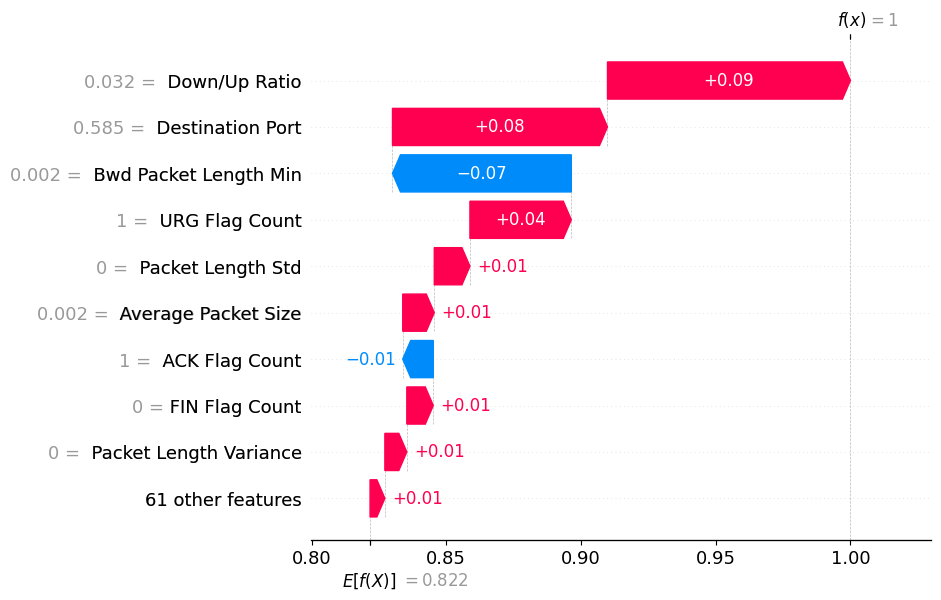

In [30]:
# plot explanations from bengin class
benign_classes = np.array(y_test[y_test['BENIGN'] == 1].index)
first_benign_index = benign_classes[0]
print(first_benign_index)
shap.waterfall_plot(shap_values[first_benign_index])

#### Malicious Class

9


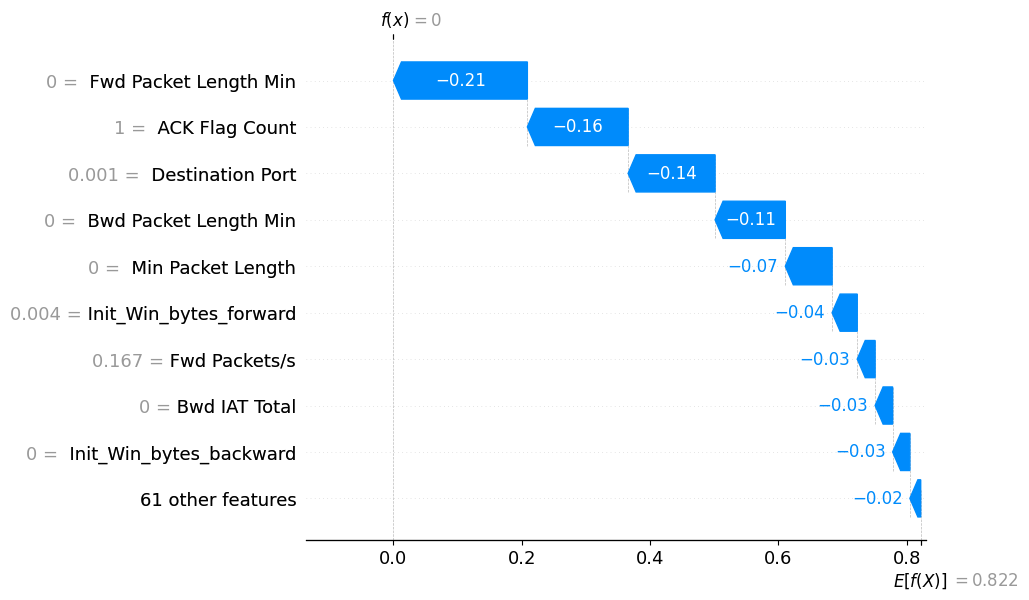

In [31]:
# plot explanations from malicious class
malicious_classes = np.array(y_test[y_test['MALICIOUS'] == 1].index)
first_malicious_index = malicious_classes[0]
print(first_malicious_index)
shap.waterfall_plot(shap_values[first_malicious_index])

### Global Models

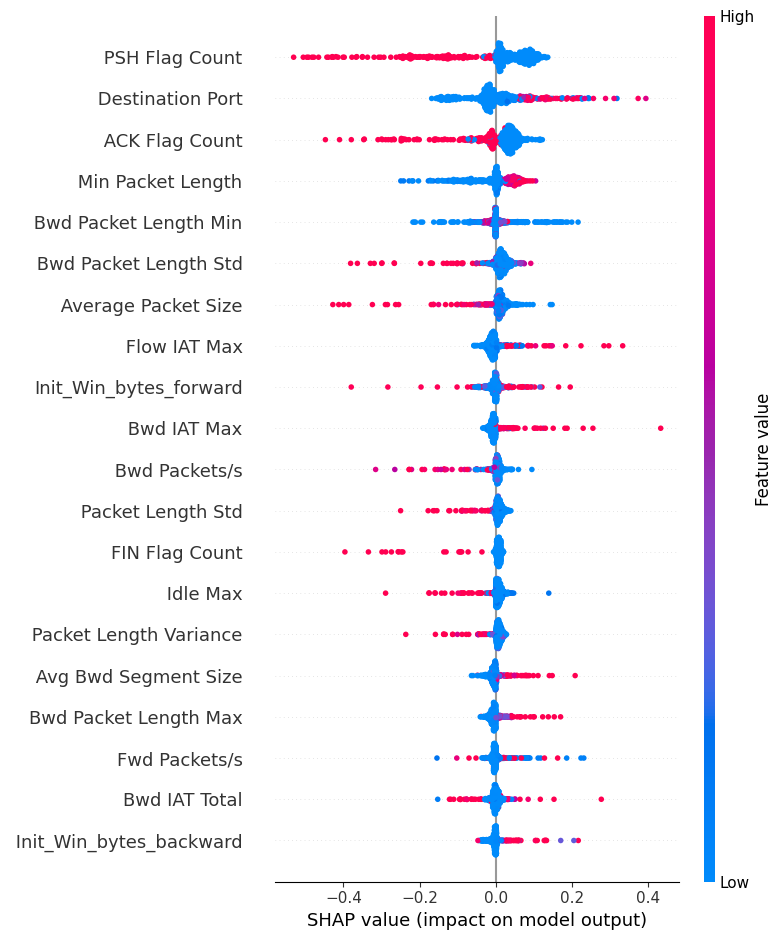

In [32]:
# summary plot
shap.summary_plot(shap_values, X_test)

#### Mean SHAP Values for Benign Class

Shap values shape: (500, 70)
Benign classes shape: (416,)
Benign shape values shape: (416, 70)


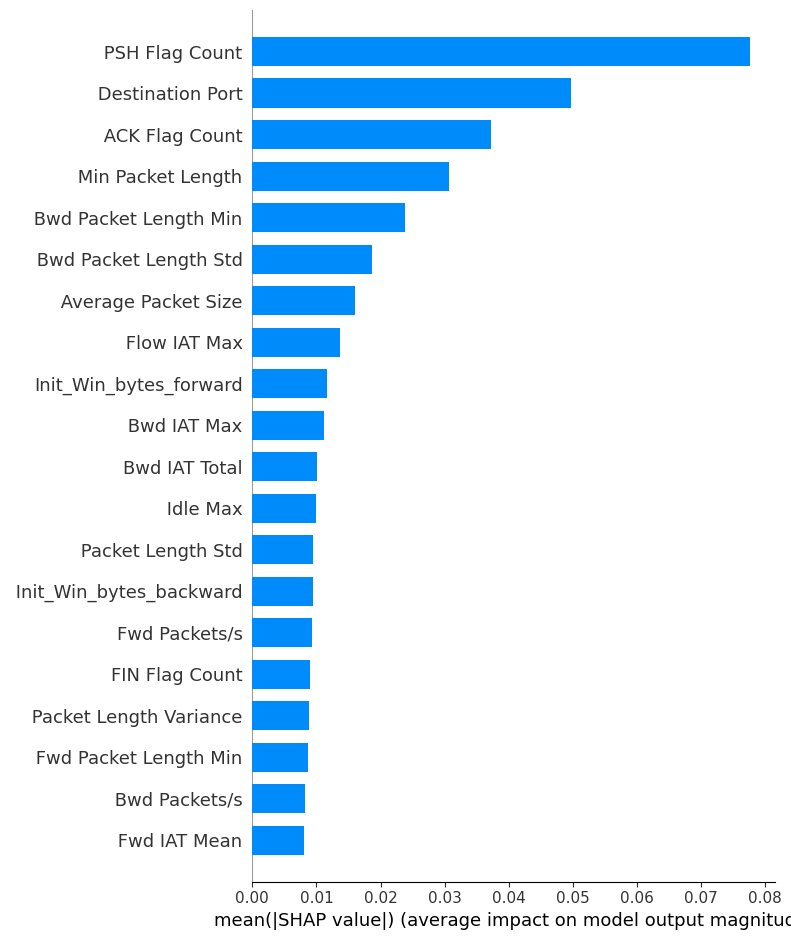

In [33]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Benign classes shape: {benign_classes.shape}")

benign_shape_values = shap_values[benign_classes]
print(f"Benign shape values shape: {benign_shape_values.shape}")
shap.summary_plot(benign_shape_values, X_train, plot_type="bar")


#### MEAN SHAP Values for Malicious Class

Shap values shape: (500, 70)
Malicious classes shape: (84,)
Malicious shape values shape: (84, 70)


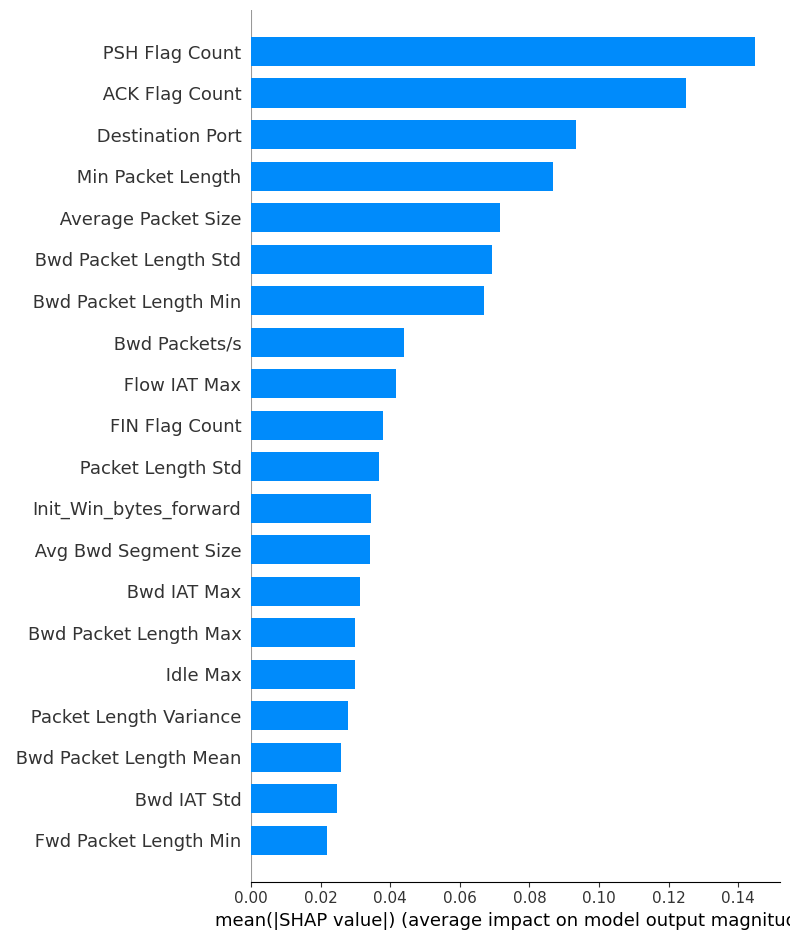

In [34]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Malicious classes shape: {malicious_classes.shape}")

malicious_shape_values = shap_values[malicious_classes]
print(f"Malicious shape values shape: {malicious_shape_values.shape}")
shap.summary_plot(malicious_shape_values, X_train, plot_type="bar")


--- 

# Adversarial Explanations

## Load Adversarial Data Samples

In [35]:
# load adversarial sample
X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_fgsm.csv")
X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_cw.csv")

## Check Performance

In [36]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy without attack: {accuracy * 100:.2f}%')

loss_adv_fgsm, accuracy_adv_fgsm = model.evaluate(X_test_adv_fgsm, y_test)
print(f'Accuracy on fgsm attack: {accuracy_adv_fgsm * 100:.2f}%')

loss_adv_cw, accuracy_adv_cw = model.evaluate(X_test_adv_cw, y_test)
print(f'Accuracy on cw attack: {accuracy_adv_cw * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9769 - loss: 0.0609 
Accuracy without attack: 98.00%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7376 - loss: 56.8195 
Accuracy on fgsm attack: 72.60%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9475 - loss: 0.0918 
Accuracy on cw attack: 94.40%


## Generate Explanations on Adversarial Data

In [67]:
# FGSM Attack
adv_explainer_fgsm = shap.Explainer(model, X_test_adv_fgsm, feature_names=X_test_adv_fgsm.columns)
adv_shap_values_fgsm = adv_explainer_fgsm(X_test_adv_fgsm)
print(adv_shap_values_fgsm.shape)

# CW Attack
adv_explainer_cw = shap.Explainer(model, X_test_adv_cw, feature_names=X_test_adv_cw.columns)
adv_shap_values_cw = adv_explainer_cw(X_test_adv_cw)
print(adv_shap_values_cw.shape)

PermutationExplainer explainer: 501it [00:30, 12.64it/s]                         


(500, 70, 2)


PermutationExplainer explainer: 501it [00:35,  9.86it/s]                         

(500, 70, 2)


In [68]:
# convert shap values to correct format
print("Convert FGSM shap values...")
print(adv_shap_values_fgsm.shape) # one shap value per feature per sample per class
adv_shap_values_fgsm = adv_shap_values_fgsm[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values_fgsm.shape) # one shap value per feature per sample

print("Convert CW shap values...")
print(adv_shap_values_cw.shape) # one shap value per feature per sample per class
adv_shap_values_cw = adv_shap_values_cw[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values_cw.shape) # one shap value per feature

Convert FGSM shap values...
(500, 70, 2)
(500, 70)
Convert CW shap values...
(500, 70, 2)
(500, 70)


## Identifying Samples Misclassified Due to Adversarial Attacks

In [40]:
print("Correct Labels:")
y_test_np = np.array(y_test).argmin(axis=1)
print(f"Prediction: {y_test_np[:20]}")

# predict samples
print("Prediction on clean samples...")
y_pred = model.predict(X_test)
print("convert to binary...")
print(y_pred.shape)
y_pred = y_pred.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(y_pred.shape)
print(f"Prediction: {y_pred[:20]}")

print("Prediction on FGSM attacked samples...")
y_pred_adv_fgsm = model.predict(X_test_adv_fgsm)
y_pred_adv_fgsm = y_pred_adv_fgsm.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_fgsm[:20]}")

print("Prediction on CW attacked samples...")
y_pred_adv_cw = model.predict(X_test_adv_cw)
y_pred_adv_cw = y_pred_adv_cw.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_cw[:20]}")

Correct Labels:
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on clean samples...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
convert to binary...
(500, 2)
(500,)
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on FGSM attacked samples...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Prediction: [1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
Prediction on CW attacked samples...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Prediction: [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1]


In [41]:
# find misclassified samples due to FGSM attack

# Find correctly classified indices
correctly_classified_indices = np.where(y_test_np == y_pred)[0]

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_fgsm = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_fgsm[correctly_classified_indices] == 0)
]
print(f"FGSM: Misclassify Begnin Traffic as Malicious: {false_negative_indices_fgsm[:10]}")
print(f"Size: {np.size(false_negative_indices_fgsm)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_fgsm = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_fgsm[correctly_classified_indices] == 1)
]
print(f"FGSM: Misclassify Malicious Traffic as Benign: {false_positive_indices_fgsm[:10]}")
print(f"Size: {np.size(false_positive_indices_fgsm)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_fgsm, false_positive_indices_fgsm])
print(f"FGSM: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

FGSM: Misclassify Begnin Traffic as Malicious: [  5  13  23  26  43  66  80  92  95 101]
Size: 54
FGSM: Misclassify Malicious Traffic as Benign: [ 9 14 15 20 31 40 61 70 71 78]
Size: 80
FGSM: All Missclassified Samples after Attack: 134


In [42]:
# find misclassified sampples due to CW attack

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_cw[correctly_classified_indices] == 0)
]
print(f"CW: Misclassify Begnin Traffic as Malicious: {false_negative_indices_cw[:10]}")
print(f"Size: {np.size(false_negative_indices_cw)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_cw = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_cw[correctly_classified_indices] == 1)
]
print(f"CW: Misclassify Malicious Traffic as Benign: {false_positive_indices_cw[:10]}")
print(f"Size: {np.size(false_positive_indices_cw)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_cw, false_positive_indices_cw])
print(f"CW: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

CW: Misclassify Begnin Traffic as Malicious: [  1  29  74 225 274 316 401 430]
Size: 8
CW: Misclassify Malicious Traffic as Benign: [ 15  71 119 135 221 228 248 266 393 432]
Size: 18
CW: All Missclassified Samples after Attack: 26


## Plot Sample Explanations that is Misclassified as Benign due to Attack

In [43]:
# find matching indices where FGSM and CW attack triggers misclassification of a malicious samples as benign
matching_indices = np.intersect1d(false_positive_indices_fgsm, false_positive_indices_cw)
print(f"Matching indices: {matching_indices[:10]}")

Matching indices: [ 15  71 119 135 221 228 248 266 393 432]


### Correct Classified

Index: 15
Prediction: 0 | 0 == Malicious, 1 == Benign


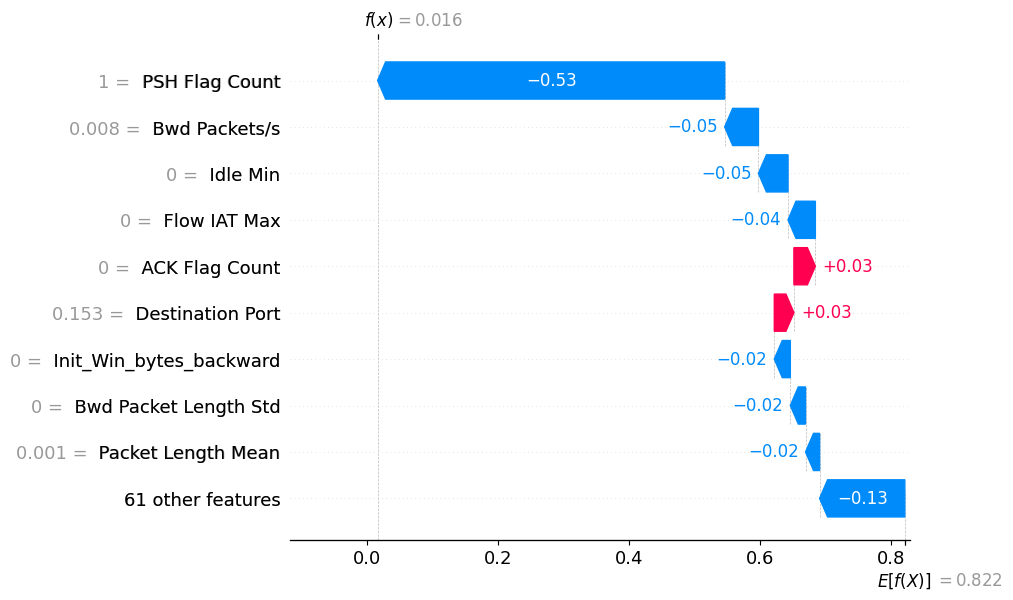

In [44]:
index = matching_indices[0]
print(f"Index: {index}")
print(f"Prediction: {y_pred[index]} | 0 == Malicious, 1 == Benign")


# plot explanation from correct classified samples
shap.waterfall_plot(shap_values[index])

### Misclassified due to Attack

Index: 15
Prediction: 1 | 0 == Malicious, 1 == Benign


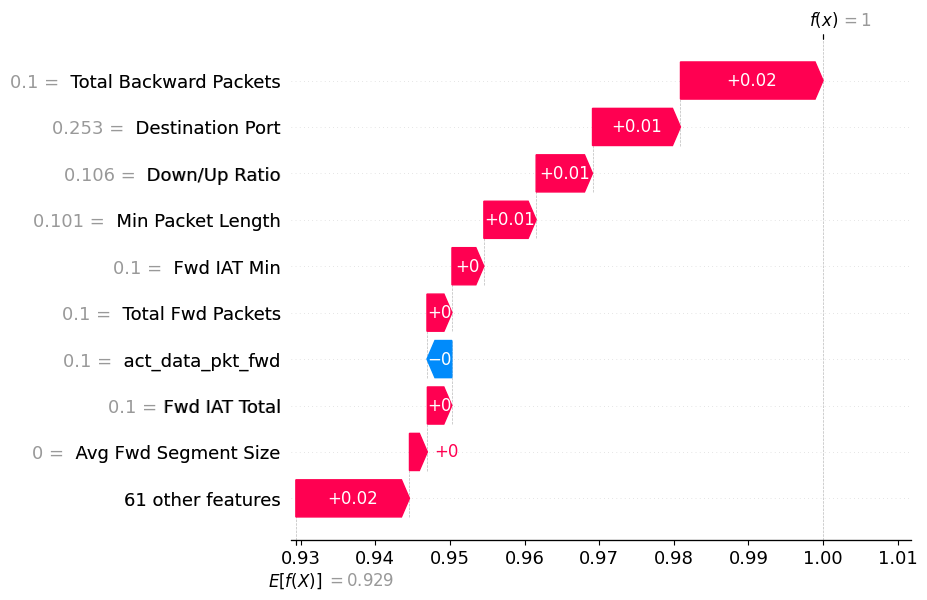

In [45]:
# FGSM attack
print(f"Index: {index}")
print(f"Prediction: {y_pred_adv_fgsm[index]} | 0 == Malicious, 1 == Benign")

# plot explanations from misclassified samples
shap.waterfall_plot(adv_shap_values_fgsm[index])

Index: 15
Prediction: 1 | 0 == Malicious, 1 == Benign


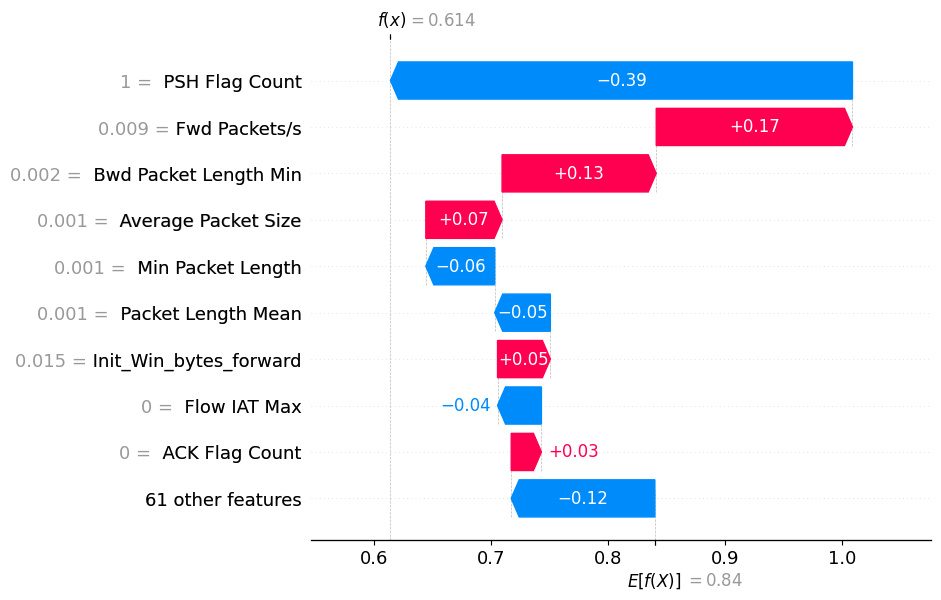

In [46]:
# CW attack
print(f"Index: {index}")
print(f"Prediction: {y_pred_adv_cw[index]} | 0 == Malicious, 1 == Benign")

# plot explanations from misclassified samples
shap.waterfall_plot(adv_shap_values_cw[index])

## ***Finding***: *Features with the highest SHAP Values are different! -> Explanation do not match to prediction!*

## Compare Values

In [61]:
local_fgsm_df = X_test_adv_fgsm.iloc[index]
#print(local_fgsm_df.to_string())

In [62]:
local_cw_df = X_test_adv_cw.iloc[index]
#print(local_cw_df.to_string())

In [63]:
local_df = X_test.iloc[index]
#print(local_df.to_string())

## Global SHAP Distribution of Attacked System

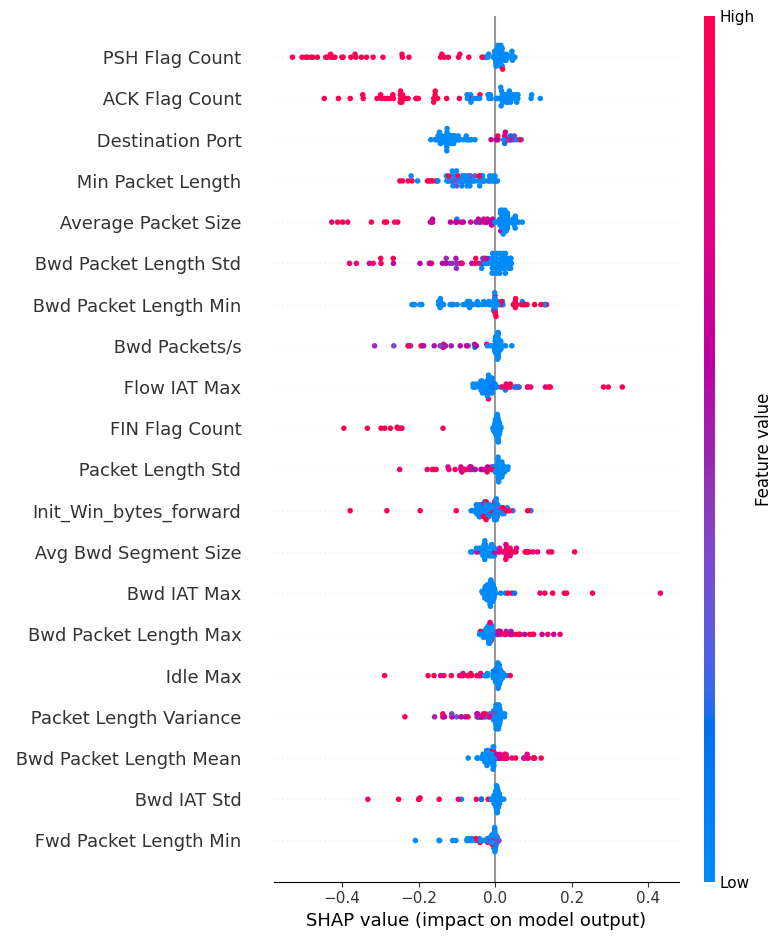

In [64]:
# plot normal
X_test_np = np.array(X_test)
shap.summary_plot(shap_values[false_positive_indices_fgsm], X_test_np[false_positive_indices_fgsm])

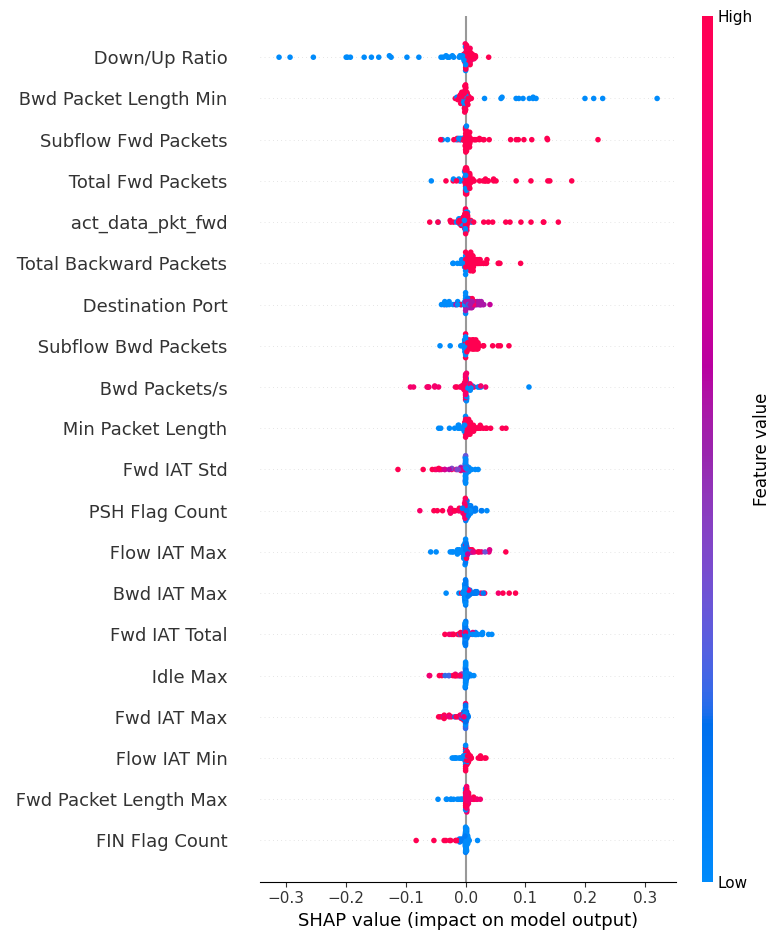

In [65]:
# plot FGSM attack
X_test_adv_np = np.array(X_test_adv_fgsm)
shap.summary_plot(adv_shap_values_fgsm[false_positive_indices_fgsm], X_test_adv_np[false_positive_indices_fgsm])

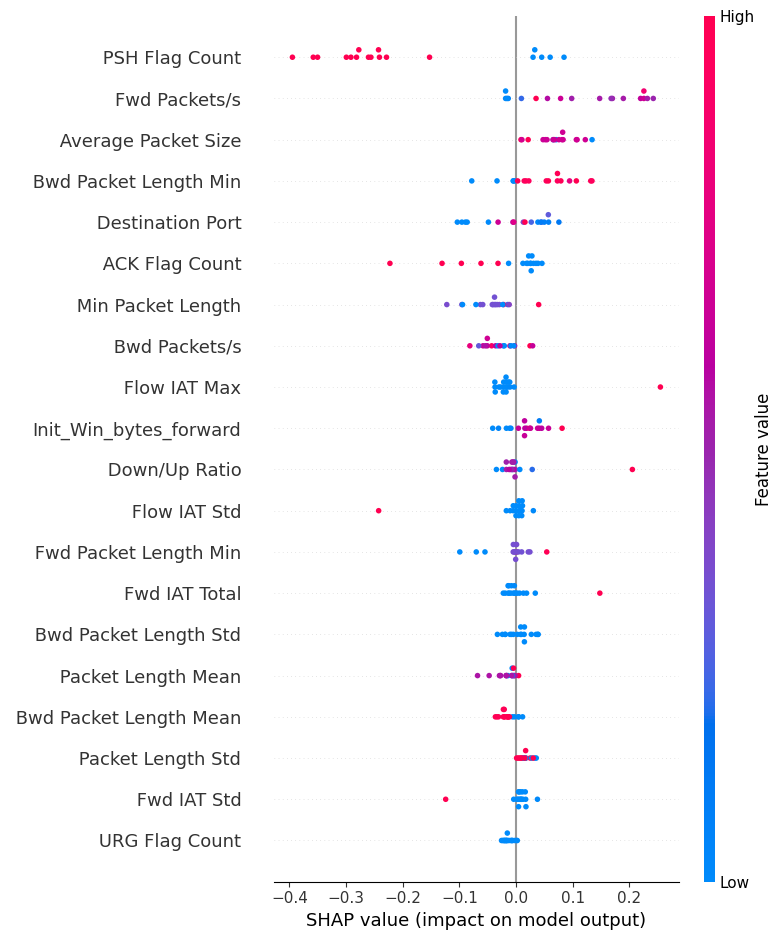

In [66]:
# plot CW attack
X_test_adv_np = np.array(X_test_adv_cw)
shap.summary_plot(adv_shap_values_cw[false_positive_indices_cw], X_test_adv_np[false_positive_indices_cw])